In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_iris
import os
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Step 1: Load the dataset

file_path = "/content/drive/MyDrive/Data Science Projects/App/app/static/license_number.csv"
data = pd.read_csv(file_path)
output_path = os.path.join("/content/drive/MyDrive/Data Science Projects/App/app/static")
os.makedirs(output_path, exist_ok=True)

In [3]:
# Step 2: Explore the data

print("Data Head:\n", data.head())
print("\nData Info:\n", data.info())
print("\nData Description:\n", data.describe())


Data Head:
   model    year  price transmission mileage fuelType    tax   mpg  engineSize  \
0    A1  2017.0  12500       Manual   15735   Petrol  150.0  55.4         1.4   
1    A6  2016.0  16500    Automatic   36203   Diesel   20.0  64.2         2.0   
2    A1  2016.0  11000       Manual   29946   Petrol   30.0  55.4         1.4   
3    A4  2017.0  16800    Automatic   25952   Diesel  145.0  67.3         2.0   
4    A3  2019.0  17300       Manual    1998   Petrol  145.0  49.6         1.0   

   tax(£) fuel type engine size mileage2 fuel type2 engine size2 reference  
0     NaN       NaN         NaN      NaN        NaN          NaN       NaN  
1     NaN       NaN         NaN      NaN        NaN          NaN       NaN  
2     NaN       NaN         NaN      NaN        NaN          NaN       NaN  
3     NaN       NaN         NaN      NaN        NaN          NaN       NaN  
4     NaN       NaN         NaN      NaN        NaN          NaN       NaN  
<class 'pandas.core.frame.DataFrame'>
R

In [4]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")



Column Details:
Column: model, Type: object, Unique values: 196
Column: year, Type: float64, Unique values: 29
Column: price, Type: object, Unique values: 19589
Column: transmission, Type: object, Unique values: 4
Column: mileage, Type: object, Unique values: 59829
Column: fuelType, Type: object, Unique values: 5
Column: tax, Type: float64, Unique values: 48
Column: mpg, Type: float64, Unique values: 208
Column: engineSize, Type: float64, Unique values: 42
Column: tax(£), Type: float64, Unique values: 24
Column: fuel type, Type: object, Unique values: 43
Column: engine size, Type: object, Unique values: 68
Column: mileage2, Type: object, Unique values: 313
Column: fuel type2, Type: object, Unique values: 4
Column: engine size2, Type: object, Unique values: 82
Column: reference, Type: object, Unique values: 9455


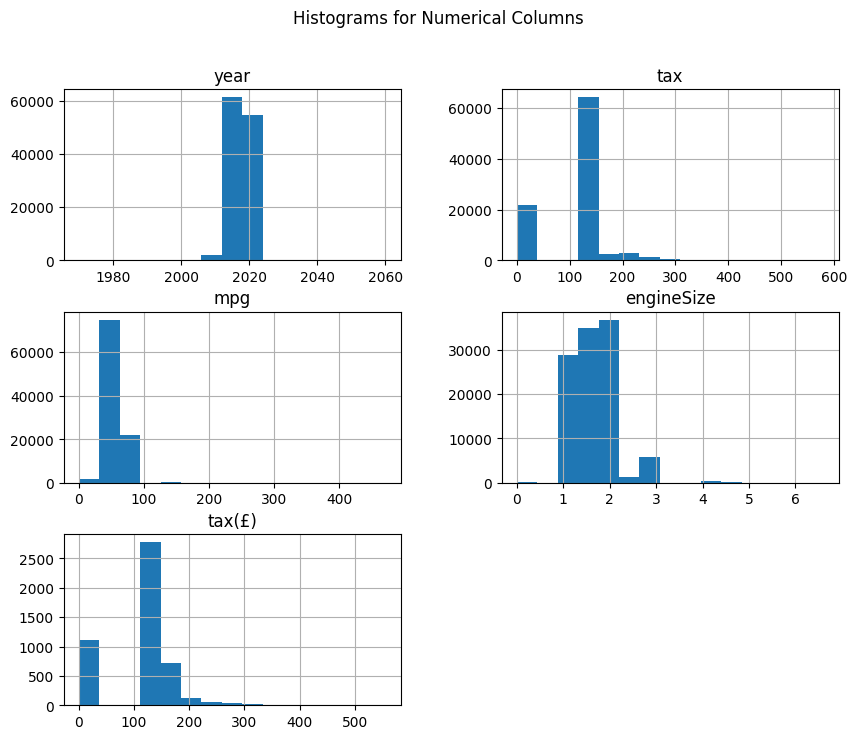

In [5]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
# plt.show()
plt.savefig(os.path.join(output_path, "license_histograms.png"))


In [6]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())

Number of missing values in each column before filling:
model              155
year               247
price              155
transmission       155
mileage           1073
fuelType          9610
tax              23823
mpg              18963
engineSize        9610
tax(£)          113290
fuel type       114633
engine size     108805
mileage2        108751
fuel type2      109613
engine size2    109613
reference       108695
dtype: int64


In [7]:
# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]


In [8]:
# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)


In [9]:
# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")



Values used to fill columns with missing values:
model:  Focus
year: 2017.1064519138613
price: 11000
transmission: Manual
mileage: 1000
fuelType: Petrol
tax: 120.2561832773225
mpg: 55.16682549124381
engineSize: 1.6616436336834348
tax(£): 121.14711934156378
fuel type: Petrol
engine size: £145
mileage2: 60.1
fuel type2: Petrol
engine size2: 1
reference: /ad/14683175


In [10]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

    # Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list


In [ ]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    # plt.show()
    plot_filename = f"license_scatter_{feature}.png"  # Use feature name in the file
    plt.savefig(os.path.join(output_path, plot_filename))

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)

In [ ]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='fuelType', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with fuelType Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "license_outliers_fuelType.png"))

sns.pairplot(data, hue='transmission', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with transmission Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "license_outliers_transmission.png"))

sns.pairplot(data, hue='engineSize', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with engineSize Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "license_outliers_engineSize.png"))


In [11]:
# Remove the outliers from the dataset

cleaned_data = data.copy()

# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers


In [ ]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='fuelType', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with fuelType Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "license_removed_outliers_fuelType.png"))

sns.pairplot(cleaned_data, hue='transmission', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with transmission Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "license_removed_outliers_transmission.png"))

sns.pairplot(cleaned_data, hue='engineSize', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with engineSize Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "license_removed_outliers_engineSize.png"))


In [12]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['fuelType'] = label_encoder.fit_transform(data['fuelType'])


In [14]:
from sklearn.preprocessing import LabelEncoder

# Ensure all categorical columns have uniform data types
for column in data.select_dtypes(include=['object']).columns:
    if column != 'fuelType':  # Avoid encoding the target variable
        # Convert all values in the column to strings
        data[column] = data[column].astype(str)

        # Apply LabelEncoder
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])


In [15]:
# Step 10: Define features (X) and target (y)

X = data.drop(columns=['fuelType'])  # Features
y = data['fuelType']  # Target variable

In [16]:
# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Step 12: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [18]:
# Step 12: Model selection and training

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}

In [20]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)


In [21]:
# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")


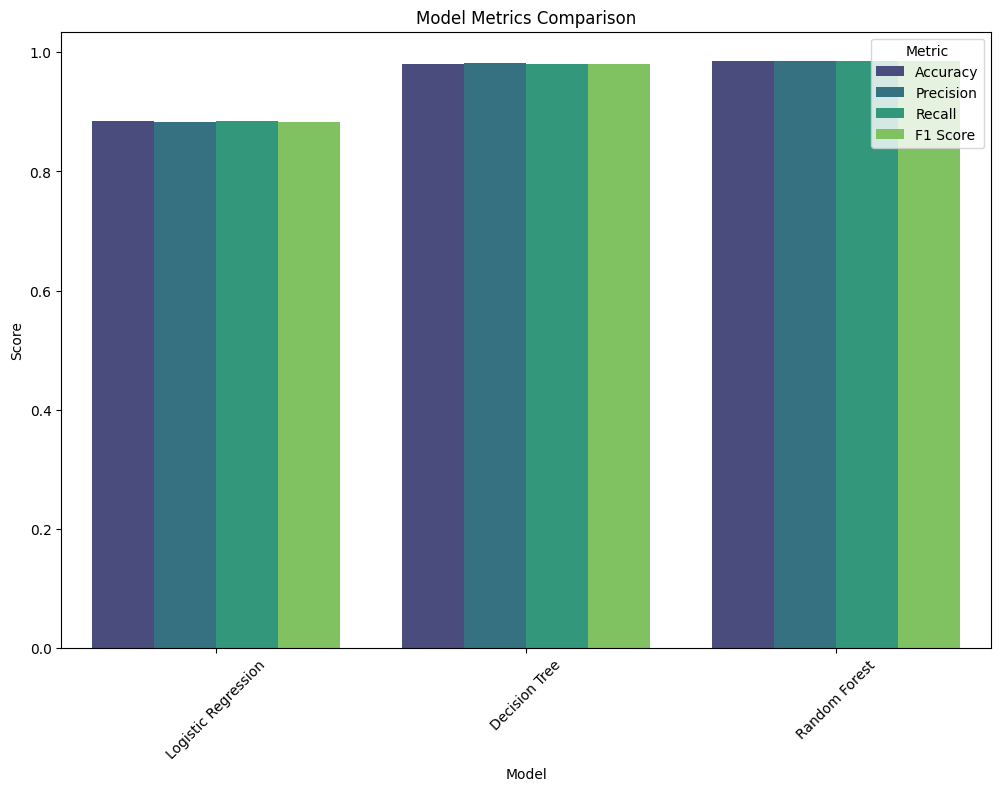

In [22]:
# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
# plt.show()
plt.savefig(os.path.join(output_path, "license_metrics.png"))


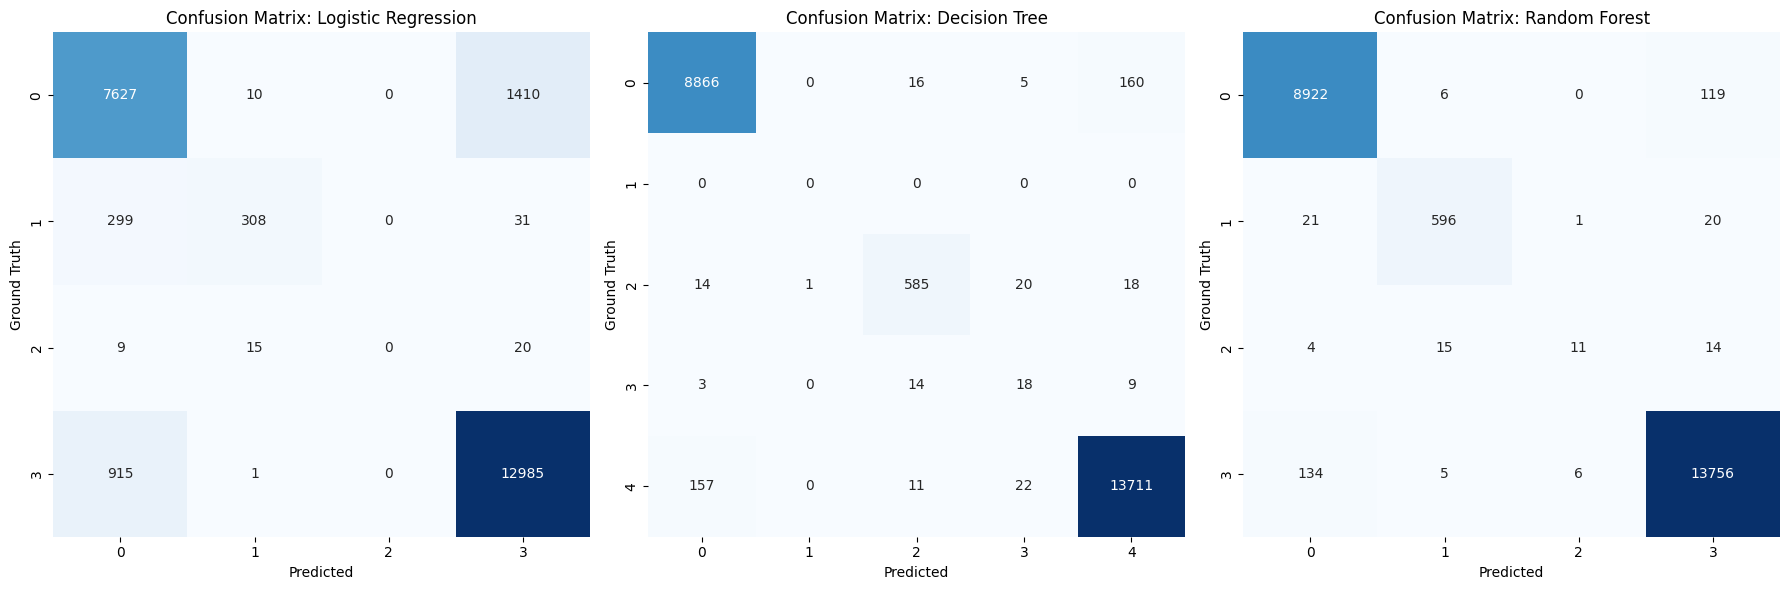

In [23]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(output_path, "license_metrix.png"))

In [24]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      9047
           2       0.92      0.48      0.63       638
           3       0.00      0.00      0.00        44
           4       0.90      0.93      0.92     13901

    accuracy                           0.89     23630
   macro avg       0.67      0.56      0.60     23630
weighted avg       0.88      0.89      0.88     23630


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9047
           1       0.00      0.00      0.00         0
           2       0.93      0.92      0.93       638
           3       0.28      0.41      0.33        44
           4       0.99      0.99      0.99     13901

    accuracy                           0.98     23630
   macro avg       0.64      0.66      0.64     23630
weighted avg       0.98      0.98      0.